# K-means Clustering on Local Neighborhoods in Atomically Resolved Images
### Alex Belianinov
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>


# Setting up the Notebook

In [1]:
# set up notebook to show plots within the notebook
% matplotlib inline

#%% Import necessary Python libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import cv2
from scipy.misc import imsave#
from sklearn.neighbors import NearestNeighbors
import math
from scipy.cluster.vq import  whiten
from sklearn.cluster import KMeans

# Tunable Parameters

In [4]:
#Image location for a raw image file (text, tiff, png, etc.)
clean_image_path = '/Users/ba8/Dropbox (ORNL)/MLMR_2018/Feature_detection_example/cracked_clean_image.png'

thresh_const = 6 #Constant for thresholding
border = 1 #How many pixels to cut off the clean image before atom finding

Exterminate = 1 #On/Off Switch for eliminating edge atoms from atom clustering
cut_val = 25 #Pixels with to eliminate from the edge of each image for atom classification
num_neighbors = 6 #Number of neighbors to designate for the atom classification
num_cluster = 4 #Number of clusters for KMeans classification

markers = {'o', '+', '*', 'x', 's', 'd', '^', 'v', '>', '<', 'p', 'h'}
color_ops = ['b','g', 'r', 'c', 'm', 'y', 'w', '#3399ff', '#660066', '#4080bf',\
              '#00ffcc', '#aa80ff', '#ff9933', '#1a1aff','#b38600', ' #77b300']
classification_cell = ['angles', 'length']
classification = [1, 2] #Designate 0, 1 for angles or 1,2 for length

# Data IO, Visualize Clean Image 

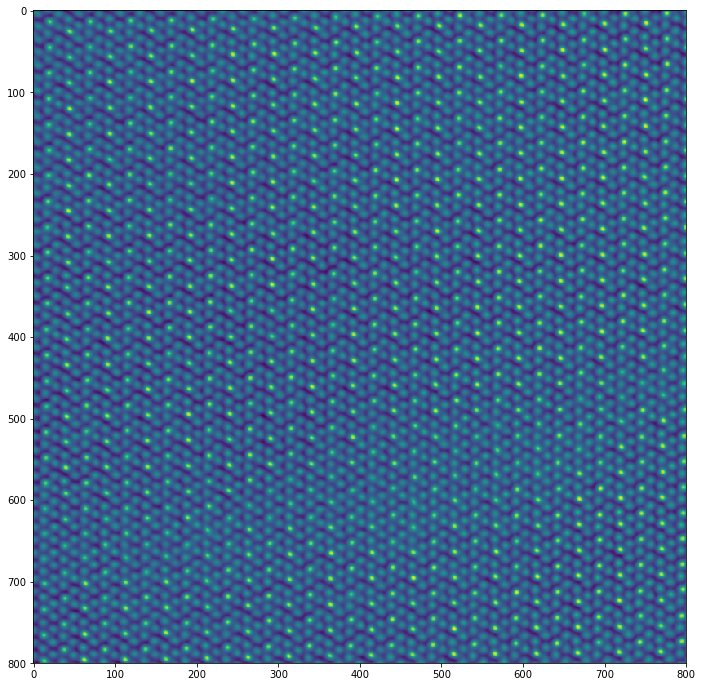

In [5]:
#%% Read cleaned image. The image in this case is a PCA cleaned image. 
# Apply thresholding function to image to identify atom positions.
img = cv2.imread(clean_image_path, 0)

#Show the Image
fig = plt.figure()
plt.figure(figsize=(12, 12))
plt.imshow(img)

# Binarize the Image by Thresholding 

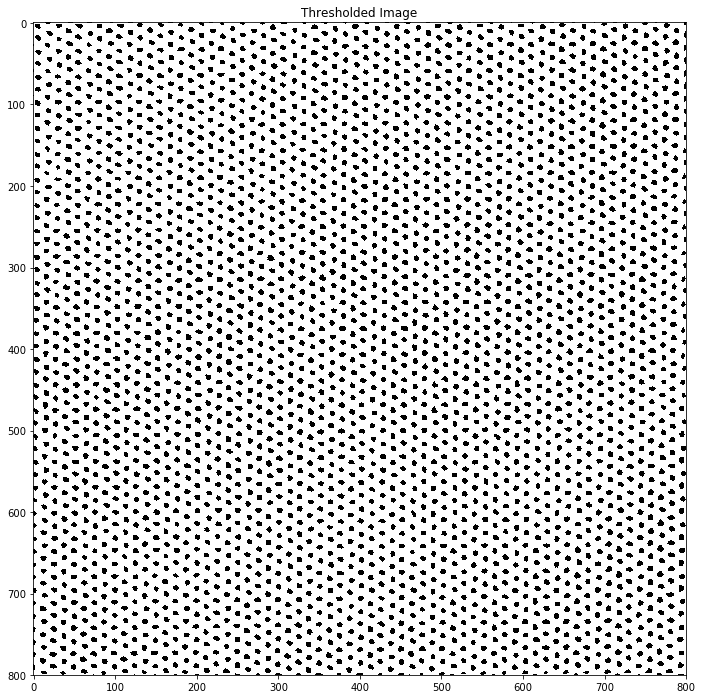

In [6]:
#Invert image because thresholding removes low intenstity values
img_inv = 255- img 
th = cv2.adaptiveThreshold(img_inv,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                           cv2.THRESH_BINARY_INV,11,thresh_const)
# Plot Thresholded Image
plt.figure(figsize=(12, 12))
plt.imshow(th, cmap='Greys')
plt.title('Thresholded Image')

# Set border on thresholded image for cropping to find atoms
th_new = th[border:-border,border:-border]

# Find the Atoms and Display Findings Over the Image

## Set the Image Border Size 

(-42.792652329749117,
 841.7926523297491,
 841.89709345106701,
 -42.897093451067107)

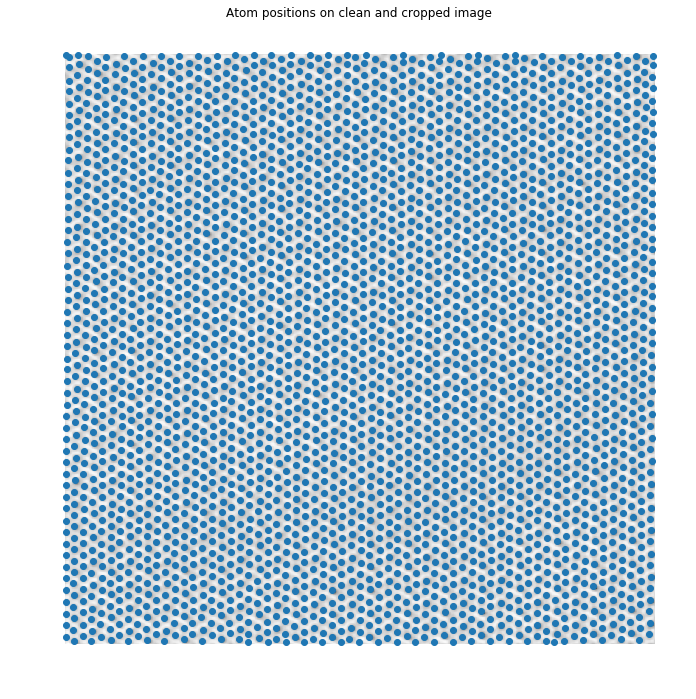

In [7]:
#%% calculate atom center of mass from atom positions. This step finds the atoms.
all_labels = measure.label(th_new)
atom_labels = measure.label(th_new)

num_atoms = np.max(atom_labels)-1
atom_positions = np.zeros(shape=(num_atoms, 2), dtype=np.uint16)

for atom_ind in range(1,num_atoms):
    atom_pixels = np.argwhere(atom_labels == atom_ind)
    atom_positions[atom_ind] = np.mean(atom_pixels, axis=0)

# Plot the atom positions on the cleaned image
plt.figure(figsize=(12,12))  
plt.imshow(img, cmap='Greys', interpolation='none') 
atom_positions = np.flipud(np.rot90(atom_positions,2)) #to orient atom_positions
                                               #with respect the the cropped image
    
plt.scatter(atom_positions[:,0] + border*np.ones(atom_positions.shape[0]), atom_positions[:,1]+ border*np.ones(atom_positions.shape[0]))
plt.title('Atom positions on clean and cropped image')
plt.axis('off')

# Save the Atom Positions & Crop Empty Image Space

In [8]:
# Saving the atom positions

folder_path = '/Users/ba8/Desktop/'

#save atom positions
x_y_positions = np.array(atom_positions, dtype='float64')
atom_path = folder_path + '/atom_positions.txt'
np.savetxt(atom_path, x_y_positions)

#cropped image 
image_cropped = img[border:-border, border:-border]

# Visualize the Cropped Image 

(-0.5, 797.5, 797.5, -0.5)

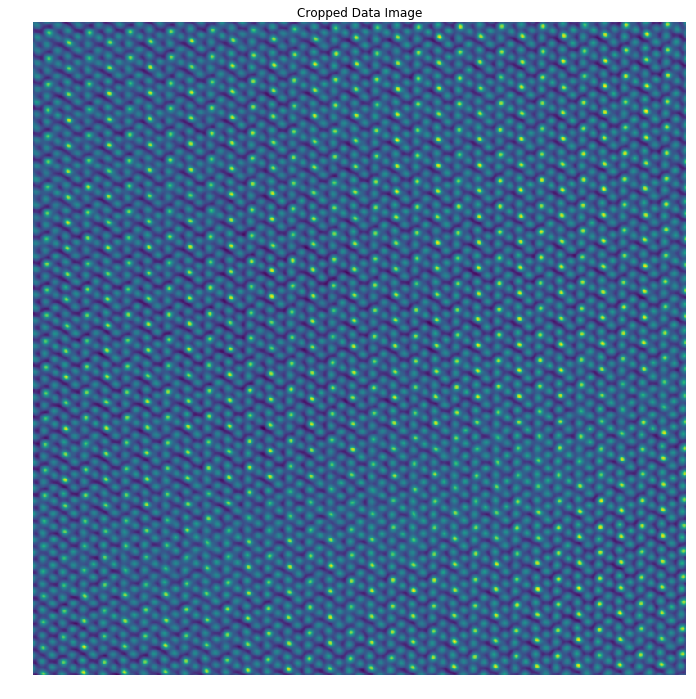

In [9]:
#%% Preparing for Atom classification
# Get the cropped image for k-means
grayatom = image_cropped

#Show image
plt.figure()
plt.figure(figsize=(12,12))  
plt.imshow(grayatom)
plt.title('Cropped Data Image')
plt.axis('off')

# Eliminate Edge Atoms as Centers and Leave them as Neighbors

In [10]:
#%% Edge Atom Eliminator for k-means algorithm 
cut_x, cut_y = grayatom.shape
x_y_positions_edge_cut = np.zeros((x_y_positions.shape[0],2))

for t in range(0,x_y_positions.shape[0]):
    
    if cut_val < x_y_positions[t,0] and x_y_positions[t,0] < cut_x-cut_val \
       and cut_val < x_y_positions[t,1] and x_y_positions[t,1] < cut_x - cut_val:
           
        x_y_positions_edge_cut[t,:] = x_y_positions[t,:]
all_x = x_y_positions_edge_cut[:,0]
all_y = x_y_positions_edge_cut[:,1]
               

# Find a Specified Number of Nearest Neighbors for All Atoms

In [11]:
#%%    Finds specified number of neighbors around (x,y) position. Outputs idices
# of all neighbors and distance to them
              
nbrs = NearestNeighbors(n_neighbors=num_neighbors+1, algorithm='brute').fit(x_y_positions)
distance_vec, full_index = nbrs.kneighbors(x_y_positions)

index = full_index[:,1:] 

# Visualize a Real Space Neighborhood Spread

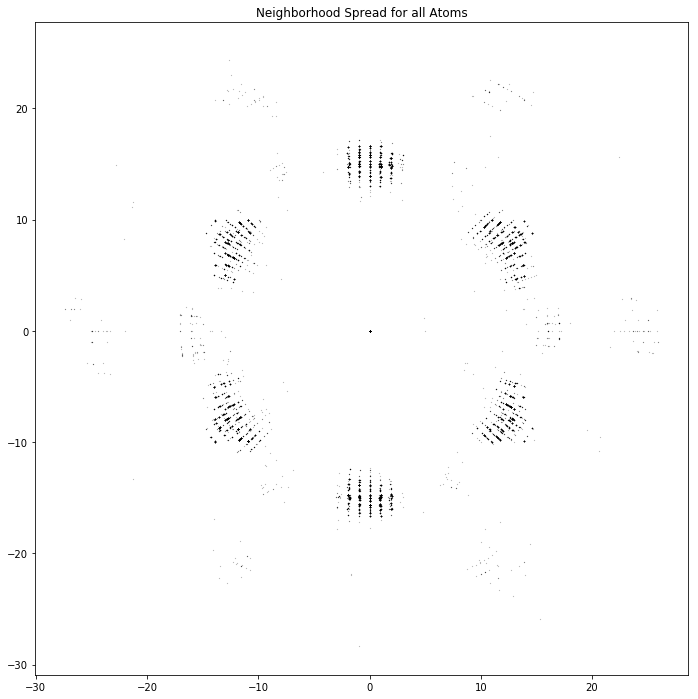

In [12]:
#%% Neighborhood Histograms

for kk in range(classification[0],classification[1]): #If by angles, range(0,1). If by distance, range(1,2)
    classify_by = classification_cell[kk]
    data_with_neighbr_cord = index   
    x_y_positions_mod = x_y_positions[:,0] + 1j*x_y_positions[:,1]
    neighbr_cord_mat= np.zeros((1,num_neighbors))
    neighbr_angle_mat = np.zeros((1,num_neighbors))
    IX_mat = np.zeros((1,num_neighbors))
    neighbr_angle = np.zeros((num_neighbors,))
    neighbr_angle_1 = np.zeros((num_neighbors,))
    neighbr_angle_mat = np.zeros((1,num_neighbors))
    
    for k1 in range(0, int(x_y_positions.shape[0])):
        neighbr_cord_0 = np.ndarray.take(x_y_positions[:,0], data_with_neighbr_cord[k1,:])
        neighbr_cord_1 = np.ndarray.take(x_y_positions[:,1], data_with_neighbr_cord[k1,:])
        neighbr_cord = np.vstack((neighbr_cord_0,neighbr_cord_1)).T

        neighbr_cord = np.vstack((neighbr_cord[:,0]-x_y_positions[k1,0],neighbr_cord[:,1]-x_y_positions[k1,1])).T

        neighbr_cord = neighbr_cord[:,0] + 1j*neighbr_cord[:,1] 
        neighbr_cord_mat = np.vstack((neighbr_cord_mat, neighbr_cord))
 
        for a in range(0,num_neighbors):
            neighbr_angle_1[a] = math.atan2(neighbr_cord[a].imag, neighbr_cord[a].real)
            
        neighbr_angle = np.vstack((neighbr_angle, neighbr_angle_1))

        IX = np.argsort(neighbr_angle)
        neighbr_angle.sort()#no need to designate axis=1
        IX = IX[1:,:]
        neighbr_angle = neighbr_angle[1:,:]
        neighbr_angle_mat = np.vstack((neighbr_angle_mat, neighbr_angle))
        IX_mat = np.vstack((IX_mat,IX))

        #Clearing cords and angles for next round
        neighbr_angle_1 = np.zeros((num_neighbors,))
        neighbr_angle = np.zeros((num_neighbors,))

    classified_index = IX_mat[1:,:]
    classified_index = classified_index.astype(int)
    classified_data = neighbr_angle_mat[1:,:]
    
    data1 = np.zeros(classified_data.shape)
    data2 = np.zeros(classified_data.shape)
    for k6 in range(0,int(x_y_positions.shape[0])):
        data1[k6,:] = np.ndarray.take(distance_vec[k6,:],classified_index[k6,:])
        data1[k6,:] = data1[k6,:] * np.cos(classified_data[k6,:])
        data2[k6,:] = np.ndarray.take(distance_vec[k6,:],classified_index[k6,:])
        data2[k6,:] = data2[k6,:] * np.sin(classified_data[k6,:])*-1
    
    plt.figure()
    plt.figure(figsize=(12,12)) 
    plt.scatter(data1,data2, color = 'k', s=.01)
    plt.axis('square')
    plt.title('Neighborhood Spread for all Atoms')
    #plt.savefig(folder_path + '/neighborhood plot.tif')
        
    if classify_by == 'length':
        D = np.zeros((int(max(x_y_positions.shape)),num_neighbors))
        for k7 in range(0, int(max(x_y_positions.shape))):
            for k8 in range(0,num_neighbors):
                X_1 = np.reshape(x_y_positions[index[k7,k8],:], (1,2)) #Calculating pdist2
                
                Q = X_1      
                P= np.reshape(x_y_positions[k7,:], (1,2))
                nP = P.shape[0]
                d = P.shape[1]
                nQ = Q.shape[0]

                P_2 = P*P
                Q_2 = Q*Q

                pmag = P_2.sum()
                qmag = Q_2.sum()

                D[k7,k8] = math.sqrt(np.ones((nP,1))*qmag.T + pmag*np.ones((1,nQ)) - 2*np.inner(P,Q))      
        IX = np.argsort(D)    
        D.sort()
        classified_index = IX
        classified_index = classified_index.astype(int)
        classified_data = D
    else:
        continue


# Cluster the Neighborhoods & Display Results

(-43.782795698924737,
 840.7827956989247,
 840.88697571743921,
 -43.886975717439356)

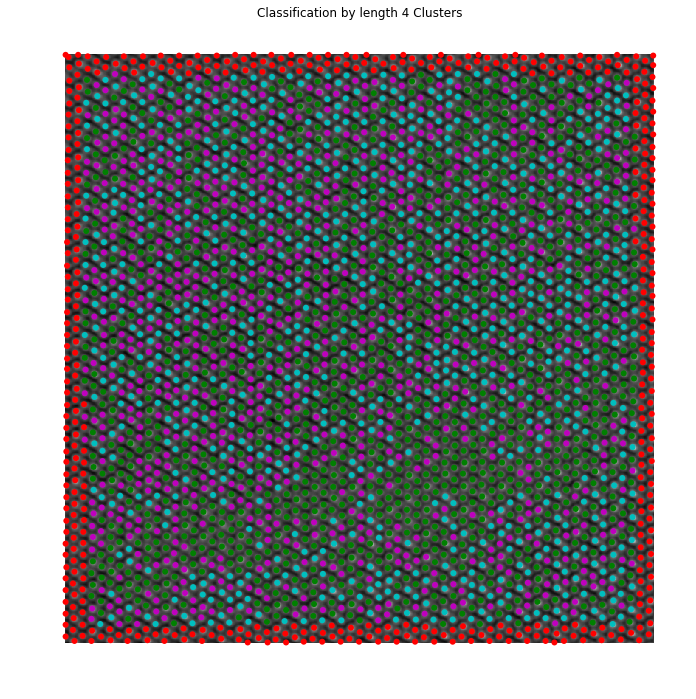

In [13]:
#%% Sorts into clusters by distance to neighbors and creates a cell with a 
#Point index for each cluter
   
if Exterminate:
    data_mat = classified_data
        
    for g in range(0,int(x_y_positions.shape[0])):
            
        if x_y_positions_edge_cut[g,0] == 0:
            data_mat[g,:] = 0
else:
    data_mat = classified_data
    
analysis_type = 'full data'
    
whiten_data = whiten(data_mat)
IDX = KMeans(n_clusters= num_cluster, max_iter=1000).fit_predict(whiten_data)
IDX = IDX + 1 #So that we don't divide by 0 later

plt.figure(figsize=(12,12))
plt.scatter(x_y_positions[:,0],x_y_positions[:,1], c= 'k', s=0.5)
plt.axis('off')
plt.imshow(image_cropped, cmap = 'gray')
for n1 in range(1, num_cluster +1):
    plt.scatter(x_y_positions[IDX == n1,0], x_y_positions[IDX == n1, 1], c = color_ops[n1], edgecolors= 'none')

plt.title('Classification by ' + classify_by + ' ' + str(num_cluster) + ' Clusters')
plt.axis('off')

# Visualize Each Cluster and Its Real Space Neighborhood Separately

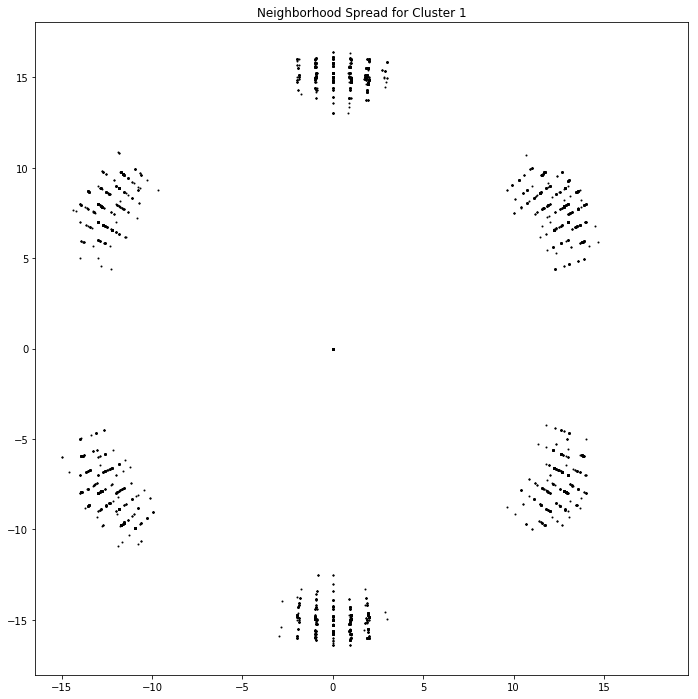

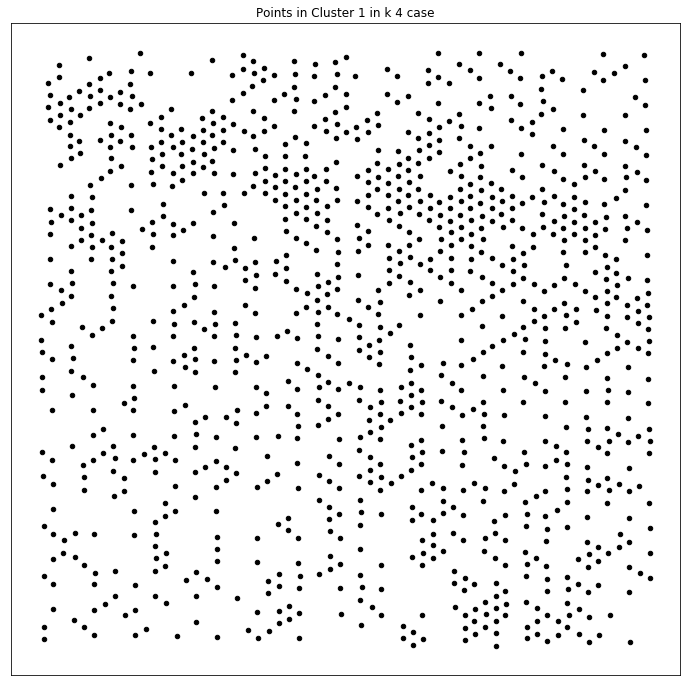

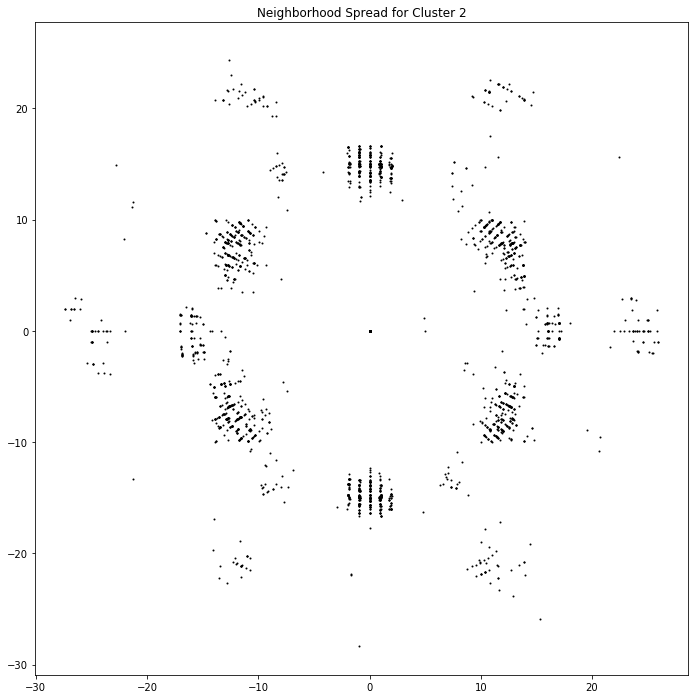

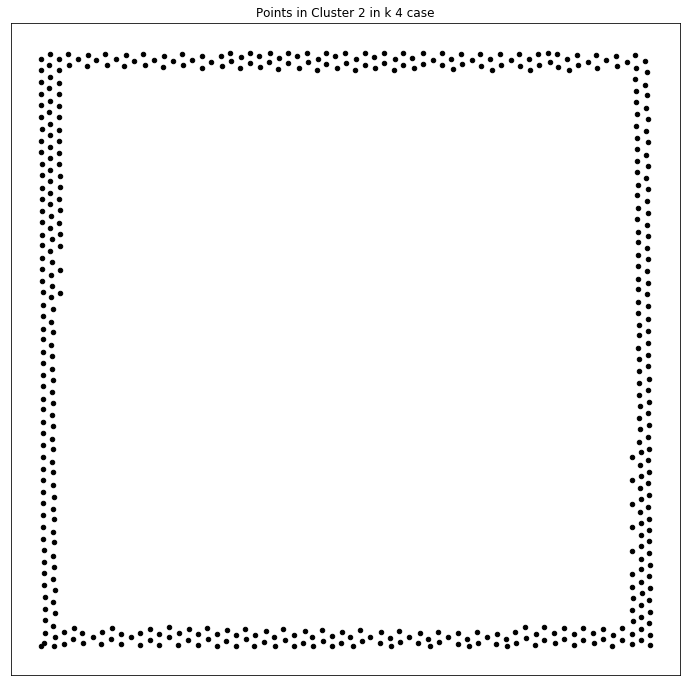

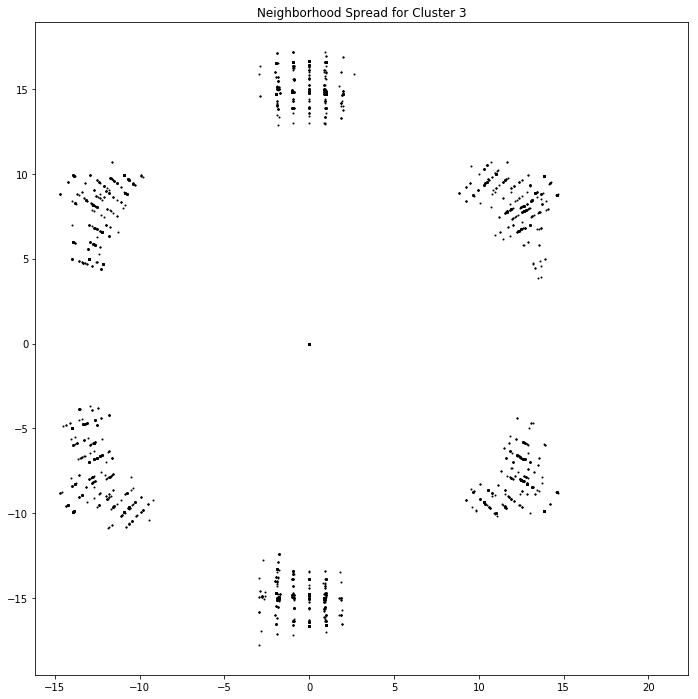

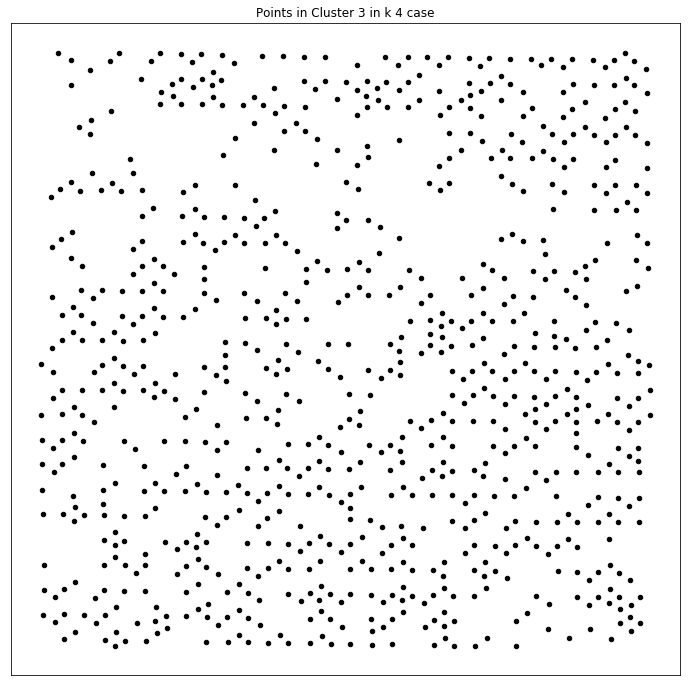

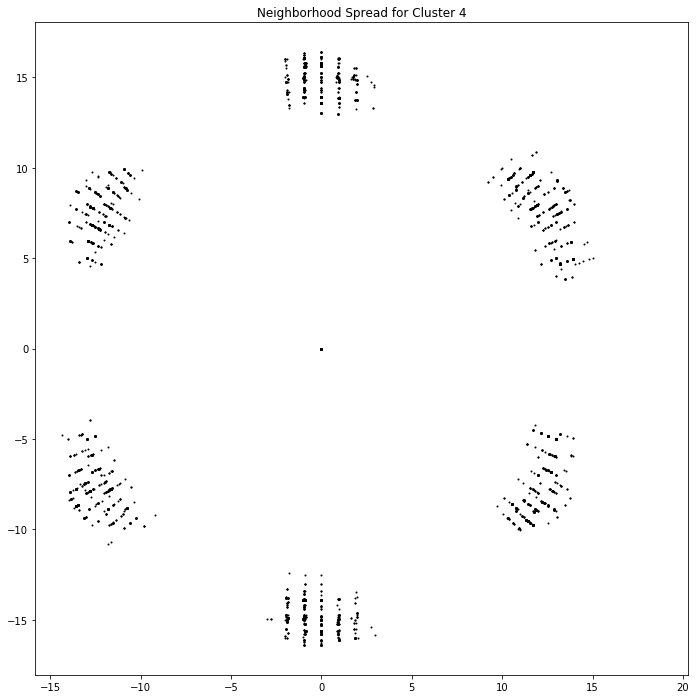

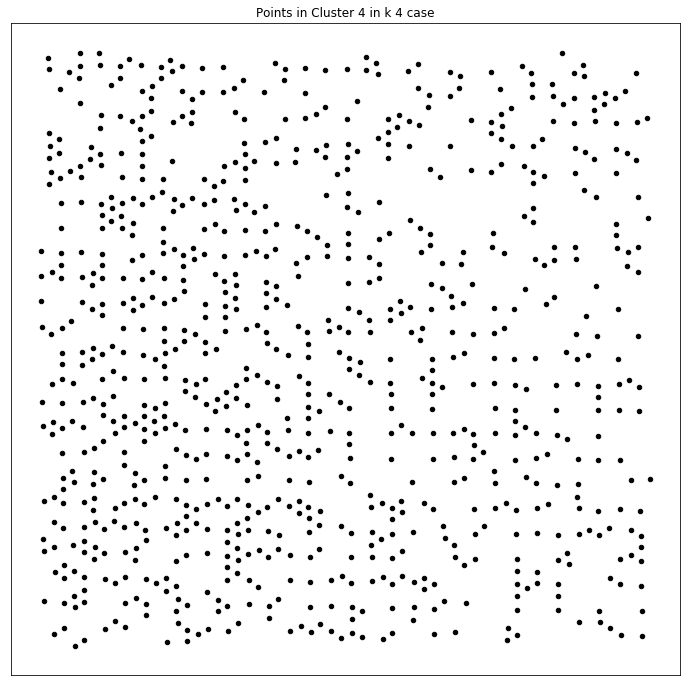

In [14]:
#%% Individualized Cluster Visualization
num_row = data_mat.shape[0]
num_col = data_mat.shape[1]
D = np.zeros((num_cluster,num_col))

for h3 in range(1,num_cluster+1):
    
    cluster = h3
    
    data3 = np.zeros(classified_data.shape)
    data3_1 = np.zeros(classified_data.shape)
    data4_1 = np.zeros(classified_data.shape)
    data4 = np.zeros(classified_data.shape)
    data5 = np.zeros(classified_data.shape)
    data6 = np.zeros(classified_data.shape)
    z = np.zeros(grayatom.shape)
    mean_idx_x = np.zeros(classified_data.shape)
    mean_idx_y = np.zeros(classified_data.shape)
    cluster_data = np.zeros(IDX.shape)
    
    cluster_boolean= IDX==h3
    cluster_bool_1_0 = np.zeros(cluster_boolean.shape)
    for i in range(0,int(cluster_boolean.shape[0])):
        if cluster_boolean[i] == True:
            cluster_bool_1_0[i] = 1
        elif cluster_boolean[i] == False:
            cluster_bool_1_0[i] = 0
    
    
    for k3 in range(0,int(IDX.shape[0])):
        
        Clus_index = np.extract(IDX == cluster, full_index)
        Class_index = np.extract(IDX == cluster,classified_data)
        
        cluster_hood = np.vstack((Clus_index, Class_index)).T
        cluster_data[k3] = IDX[k3] * cluster_bool_1_0[k3]
        
        data3[k3,:] = data1[k3,:] * cluster_data[k3]
        data4[k3,:] = data2[k3,:] * cluster_data[k3]
        
        data3_1[k3,:] = data1[k3,:] * (cluster_data[k3]/cluster)
        data4_1[k3,:] = data2[k3,:] * (cluster_data[k3]/cluster)
        
        if cluster_data[k3] == cluster:
            
            data5[k3,:] = data1[k3,:] * (cluster_data[k3]/cluster)
            data6[k3,:] = data2[k3,:] * (cluster_data[k3]/cluster)
            
            mean_idx_x[k3,:] = data1[k3,:] * (cluster_data[k3]/cluster)
            mean_idx_y[k3,:] = data2[k3,:] * (cluster_data[k3]/cluster)
            
        else:
            
            data3[k3,:] = float('Inf') 
            data4[k3,:] = float('Inf') 
            
            data5[k3,:] = float('Inf') 
            data6[k3,:] = float('Inf') 
            
            mean_idx_x[k3,:] = float('Inf') 
            mean_idx_y[k3,:] = float('Inf') 
    
    #Plotting Neighborhood Spread for cluster
    plt.figure()
    plt.figure(figsize=(12,12))
    plt.scatter(data1[IDX==cluster,:],data2[IDX==cluster,:], color = 'k', s=1)
    plt.axis('square')
    plt.title('Neighborhood Spread for Cluster ' + str(h3))
    
    #Plotting Points in Cluster, the short way
    fig = plt.figure(figsize=(12,12))
    ax = plt.scatter(x_y_positions[IDX==cluster,0],x_y_positions[IDX==cluster,1], color = 'k',s=20)
    plt.axis('tight')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Points in Cluster ' + str(h3) + ' in k ' + str(num_cluster) + ' case')
   